# Topic analysis

Measure political party similarities over time.
1. Based on political topics:
    For each word (e.g., economy) measure the word overlap of the 10-20 nearest neighbours between parties.

2. Based on name embeddings:
    Word overlap of the 10-20 nearest neighbours.


### 1. Overlap of nearest neighbors for selected topics (kaiti and dina)

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import string

from string import digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
generic_topics = ['παιδεία', 'υγεία', 'οικονομία', 'δικαιοσύνη', 'εργασία', 
                  'περιβάλλον', 'πολιτισμός', 'εμπόριο', 'θρησκεία', 'τεχνολογία', 'άμυνα']

Description: We want to see what each political party says over some specific topics (defined above) through time. Train word2vec for one political party (νδ or συριζα or πασοκ) for all its periods. Then for each of the generic_topics, find the 15 nearest neighbors, stem them and compute the jaccard similarity.

Read tell_all_corrected.csv, group by period and political party and join speeches. 

In [3]:
%%time
data = pd.read_csv('../out_files/tell_all_corrected.csv', nrows=300000)

data = data.drop(data[data.political_party == 'αντιπολιτευση'].index) #remove rows from αντιπολιτευση or βουλη
data = data.drop(data[data.political_party == 'βουλη'].index)
data = data.drop(data[data.political_party == 'εξωκοινοβουλευτικός'].index)

grouped_data = data.groupby(['parliamentary_period','political_party'])['speech'].apply(' '.join).reset_index()
grouped_data['speech'] = grouped_data['speech'].str.lower()

CPU times: user 10.4 s, sys: 1.09 s, total: 11.5 s
Wall time: 12.1 s


In [33]:
data[['sitting_date', 'parliamentary_period']]

sitting_date parliamentary_period
0        03/07/1989             period 5
1        03/07/1989             period 5
2        03/07/1989             period 5
4        03/07/1989             period 5
5        04/07/1989             period 5
...             ...                  ...
299995   10/06/1998             period 9
299996   10/06/1998             period 9
299997   10/06/1998             period 9
299998   10/06/1998             period 9
299999   10/06/1998             period 9

[285215 rows x 2 columns]

In [39]:
f"{data.loc[data.parliamentary_period == 'period 5'].sitting_date.min()} \
  - {data.loc[data.parliamentary_period == 'period 5'].sitting_date.max()}"

'01/09/1989   - 29/09/1989'

In [6]:
#from tqdm import tqdm
#from gensim.models import Word2Vec
#import nltk

#!mkdir ../out_files/wordmodels/PERperiod_PERparty/

#model = Word2Vec(sentences=[nltk.word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(nd_period5)], 
#                 size=100, window=5, min_count=1, workers=4)
#model.save("../out_files/wordmodels/PERperiod_PERparty/period5.mdl")

#model = Word2Vec(sentences=[nltk.word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(nd_period6)], 
#                 size=100, window=5, min_count=1, workers=4)
#model.save("../out_files/wordmodels/PERperiod_PERparty/period6.mdl")

Load the two trained word2vec models and align the one to the other. You will need procrustes but don't try to understand the code. If you want to get the basic idea, read this https://www.samtalksml.net/aligning-vector-representations/

Compute the jaccard similarity of the two lists of stemmed nearest neighbors. Use the following example code I wrote in the colab notebook. However, instead of years, use periods.

In [4]:
import string
import itertools

def jaccard_metrics(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    intersection = len(s1.intersection(s2))
    union = len(s1.union(s2))
    jaccard = float(intersection/union)
    return jaccard, intersection, union

def compute_jacc_sim(term, year_pairs):

  term_subdf = ms_df.copy().loc[(ms_df.topic==term)]
  term_subdf['top100words'] = term_subdf.top100_word_sim_vector.apply(lambda x: [l[0] for l in x])
  term_subdf['top100words'] = term_subdf.top100words.apply(lambda x: [
      w.translate(str.maketrans('', '', string.punctuation)) for w in x if w!='']) # remove punctuation

  sim_list = []

  for pair in year_pairs:
      #list1 = term_subdf[term_subdf.year==pair[0]].top100words.iloc[0]
      #list2 = term_subdf[term_subdf.year==pair[1]].top100words.iloc[0]
      jac_sim, intersection, union = jaccard_metrics(stemmed_words[0], stemmed_words[1])
      sim_list.append([term, pair, jac_sim, intersection, union])

  return(sim_list)

#year_pairs = list(itertools.combinations(range(2015,2020), 2))
# year_pairs.append((2015,2015))

#all_sims = []

#for term in all_words:
#  term_sims = compute_jacc_sim(term, year_pairs)
#  all_sims+=term_sims

#jaccard_df = pd.DataFrame(data=all_sims, columns = ['term', 'pairs', 'jaccard_sim', 'word_intersection', 'word_union'])
#print(jaccard_df.head(5))


Adjust all the steps above to implement it for all the periods of this political party. Not only two. A thought: the names of the periods (period 1, period 2 ...) ensure the correct chronological order of our comparisons, because we want to compare each period with its next one. 

1) Use Word2Vec

In [6]:
%%time
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
for party in grouped_data.political_party.unique():
  period_number = 4
  for period in grouped_data.parliamentary_period.unique():
    if not grouped_data['speech'].loc[(grouped_data.political_party == party) &
                 (grouped_data.parliamentary_period == period)].empty:
      per_period_speeches = grouped_data['speech'].loc[(grouped_data.political_party == party) &
                 (grouped_data.parliamentary_period == period)].values[0]
      print(per_period_speeches[:100])
      model = Word2Vec(sentences=[nltk.word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(per_period_speeches)], 
                   size=100, window=5, min_count=1, workers=4)
      period_number+=1
      model.save(f"../out_files/wordmodels/PERperiod_PERparty/{party}_period{period_number}.mdl")

αυτό, το οποίο είναι σημαντικό, αξιότιμες κυρίες και αξιότιμοι κύριοι συνάδελφοι, σ` αυτήν την περίο
 η επαναφορά της ενισχυμένης αναλογικής θα είχε ως συνέπεια να ενταθούν οι διχαστικές τάσεις και να 
 η βουλή εγκρίνει. κύριοι συνάδελφοι, εισερχόμαστε στην ημερήσια διάταξητης νομοθετικης εργασιας θα 
 κύριοι συνάδελφοι, έχω την τιμή να ανακοινώσω στο σώμα, ότι εκ μέρους του προέδρου της κυβερνήσεως 
 με την φ142/3236/2277/1.12.89 απόφαση της δ/νσης βιομηχανίας αχαΐας είχε χορηγηθεί εξάμηνη προθεσμί
 κύριοι συνάδελφοι, εισερχόμαστε στην ημερήσια διάταξη της νομοθετικης εργασιασσυνέχιση της συζήτηση
 κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας την προεδρία του σώματος θα ήθελα κατ' αρχήν να ευχαρι
κυρίες και κύριοι συνάδελφοι, η βουλή αυτή θα ονομασθεί στην ελληνική πολιτική ιστορία ως βουλή εθνι
 κυρίες και κύριοι συνάδελφοι, ευχαριστώ για την επανεκλογή μου και τους συναδέλφους που με εψήφισαν
 τον αχελώο δηλαδή; ανδρεας γ.  κυρίες και κύριοι συνάδελφοι, παρακολούθησα με ενδιαφέρον τ

2) Find the top neighbours and stem them

In [20]:
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk

party_sims = []
parties = []
periods = []
for party in grouped_data.political_party.unique():
  period_number = 4
  for period in grouped_data.parliamentary_period.unique():
    if not grouped_data['speech'].loc[(grouped_data.political_party == party) &
                 (grouped_data.parliamentary_period == period)].empty:
        #print(f"{party}_period{period_number}")
        period_number+=1
        model = Word2Vec.load(f"../out_files/wordmodels/PERperiod_PERparty/{party}_period{period_number}.mdl")
        #print(party)
        #print(model.wv.vocab)
        if 'οικονομία' in model.wv.vocab:
          sims = {k:s for k,s in model.wv.most_similar(positive=["οικονομία"], topn=15)} # (kaiti) change topn = 10 to topn =15
          #print(' '.join(sims))
          party_sims.append(' '.join(sims))
          parties.append(party)
          periods.append(period)
        
dict = {'party': parties, 'period': periods, 'neighbors': party_sims} 
nearest_neighbors_sims = pd.DataFrame(dict)

In [21]:
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()

stemmed_neighbors = nearest_neighbors_sims['neighbors']
stemmed_neighbors = stemmed_neighbors.str.lower() # make it lower() for maketrans to match below
stemmed_neighbors = stemmed_neighbors.str.translate(
                 str.maketrans('άέόώήίϊΐύϋΰ', 'αεοωηιιιυυυ'))
stemmed_neighbors = stemmed_neighbors.str.upper()

stemmed_words = []
for i in stemmed_neighbors:
  words = nltk.word_tokenize(i)
  stemmed_words.append([stemmer.stem(word) for word in words])
print(stemmed_words)

[['ΑΝΥΠΑΡΚΤ', 'ΔΙΩΞ', 'ΛΟΓ', 'ΔΙΚΑΙΩΜ', 'ΣΥΜΒΟΥΛ', 'ΕΚΕΙΝ', 'ΤΥΠ', 'ΣΕΒ', 'ΕΚΦΡΑΖ', 'ΠΕΡΙΟΡΙΣΜ', 'ΟΤΙΔΗΠΟΤ', 'ΜΕΓΑΛ', 'ΛΑ', 'ΚΑΘΟΛΟΥ', 'ΕΙΛΙΚΡΙΝ'], ['ΠΡΑΓΜΑΤΙΚΟΤΗΤ', 'ΕΛΛΑΔ', 'ΟΥΣ', 'ΕΛΛΗΝ', 'ΑΡΧ', 'ΕΘΝ', 'ΑΤΜΟΣΦΑΙΡ', 'ΚΑΤΑΣΤΑΣ', 'ΑΝΑΚΡΙΣ', 'ΣΥΜΦΩΝ', 'ΛΟΓΙΚ', 'ΠΟΛΙΤΕΙ', 'ΑΡΙΣΤΕΡ', 'ΠΡΑΚΤ', 'ΚΟΙΝΩΝ'], ['ΚΑΤΑΣΤΑΣ', 'ΠΡΑΓΜΑΤΙΚΟΤΗΤ', 'ΛΥΣ', 'ΣΩΣΤ', 'ΦΟΡΟΔΙΑΦΥΓ', 'ΑΛΛ', 'ΠΟΛΙΤ', 'ΜΕΓΑΛ', 'ΘΕΣ', 'ΙΣΤΟΡ', 'ΚΡΙΣ', 'ΕΠΕΡΩΤΗΣ', 'ΩΡ', 'ΚΑΛ', 'ΑΝΤΙΛΗΨ'], ['ΚΟΙΝΩΝ', 'ΠΑΙΔΕΙ', 'ΓΕΩΡΓ', 'ΕΥΡΩΠ', 'ΑΝΕΡΓ', 'ΤΟΥΡΚ', 'ΕΛΛΑΔ', 'ΑΓΟΡ', 'ΑΜΥΝ', 'ΠΡΑΓΜΑΤΙΚΟΤΗΤ', 'ΚΤΗΝΟΤΡΟΦ', 'ΠΡΟΟΔ', 'ΤΡΟΜΟΚΡΑΤ', 'ΠΟΡΕΙ', 'ΥΠΟΔΟΜ'], ['ΚΟΙΝΩΝ', 'ΥΠΟΔΟΜ', 'ΕΘΝ', 'ΑΝΤΙΠΡΟΣΩΠΕΙ', 'ΠΟΛΙΤΕΙ', 'ΚΑΤΑΣΤΑΣ', 'ΑΣΦΑΛΙΣ', 'ΠΑΙΔΕΙ', 'ΥΓΕΙ', 'ΤΕΧΝΟΛΟΓ', 'ΠΡΟΕΔΡ', 'ΩΦΕΛΕΙ', 'ΕΥΡΩΠ', 'ΠΟΡΕΙ', 'ΑΝΑΠΤΥΞ'], ['ΚΟΙΝΩΝ', 'ΠΑΙΔΕΙ', 'ΑΣΤΥΝΟΜ', 'ΕΥΡΩΠ', 'ΚΤΗΝΟΤΡΟΦ', 'ΕΛΛΑΔ', 'ΠΕΡΙΦΕΡΕΙ', 'ΥΦΕΣ', 'ΑΝΑΠΤΥΞ', 'ΤΗΛΕΟΡΑΣ', 'ΚΟΙΝΟΤΗΤ', 'ΑΓΟΡ', 'ΤΑΞ', 'ΥΠΑΙΘΡ', 'ΕΛΛΗΝ'], ['ΑΝΤΑΓΩΝΙΣΤΙΚΟΤΗΤ', 'ΕΛΛΗΝ', 'ΑΝΑΓΚΑΙ', 'ΑΠΟΛΥΤ', 'ΑΝΤΙΣΤΑΣ', 'ΤΡΙΤ', 'ΣΥΜΦΩΝ', 'ΜΕΤΑΧ

In [40]:
period_dates = []
for period in nearest_neighbors_sims.period:
    period_dates.append(f"{data.loc[data.parliamentary_period == period].sitting_date.min()} \
      - {data.loc[data.parliamentary_period == period].sitting_date.max()}")

In [41]:
nearest_neighbors_sims['stemmed neighbors'] = stemmed_words
nearest_neighbors_sims['period with dates'] = period_dates

In [43]:
nearest_neighbors_sims

party    period  \
0                                δημοκρατικη ανανεωση  period 5   
1                                      νεα δημοκρατια  period 5   
2                                      νεα δημοκρατια  period 6   
3                                      νεα δημοκρατια  period 7   
4                                      νεα δημοκρατια  period 8   
5                                      νεα δημοκρατια  period 9   
6                      πανελληνιο σοσιαλιστικο κινημα  period 5   
7                      πανελληνιο σοσιαλιστικο κινημα  period 6   
8                      πανελληνιο σοσιαλιστικο κινημα  period 7   
9                      πανελληνιο σοσιαλιστικο κινημα  period 8   
10                     πανελληνιο σοσιαλιστικο κινημα  period 9   
11  συνασπισμος της αριστερας των κινηματων και τη...  period 5   
12  συνασπισμος της αριστερας των κινηματων και τη...  period 6   
13  συνασπισμος της αριστερας των κινηματων και τη...  period 7   
14  συνασπισμος της αριστερας των κινηματων και τη...  period 9   
15                       ανεξαρτητοι (εκτος κομματος)  period 7   
16  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  period 6   
17  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  period 7   
18                        κομμουνιστικο κομμα ελλαδας  period 7   
19                        κομμουνιστικο κομμα ελλαδας  period 8   
20                        κομμουνιστικο κομμα ελλαδας  period 9   
21                                    πολιτικη ανοιξη  period 8   
22                       δημοκρατικο κοινωνικο κινημα  period 9   

                                            neighbors  \
0   ανυπάρκτου διώξεως λόγος δικαιώματα συμβουλίου...   
1   πραγματικότητα ελλάδα ουσία ελληνική αρχή εθνι...   
2   κατάσταση πραγματικότητα λύση σωστή φοροδιαφυγ...   
3   κοινωνία παιδεία γεωργία ευρώπη ανεργία τουρκί...   
4   κοινωνία υποδομή εθνική αντιπροσωπεία πολιτεία...   
5   κοινωνία παιδεία αστυνομία ευρώπη κτηνοτροφία ...   
6   ανταγωνιστικότητα ελληνική αναγκαία απόλυτη αν...   
7   κατάσταση πόλη προσπάθεια πολιτική διάταξη παρ...   
8   κοινωνία άμυνα κτηνοτροφία αγορά ευρώπη βιομηχ...   
9   κοινωνία παιδεία ευρώπη πατρίδα κατάσταση υγεί...   
10  κοινωνία παιδεία ευρώπη κτηνοτροφία ποιότητα ε...   
11  πληροφόρηση προς δημόσια συντηρητική ελληνική ...   
12  ανάπτυξη ελληνική κοινή είτε ρύθμιση απόφαση κ...   
13  κοινωνία αγορά ευρώπη πορεία κοινότητα πρωτεύο...   
14  κρίση τράπεζα στρατηγική παιδεία ενημέρωση κυβ...   
15  άρθρο οικονομική ως ένα της ... του εδώ των αν...   
16  λόγος οικονομική της πόρων τη οικολόγων αντίθε...   
17  ήδη μία τόσο αποτελεί ας σελιδα αφού μια κάποι...   
18  αγροτική εθνική άμυνα ανάπτυξη ασφάλεια οικονο...   
19  αγροτική ανάπτυξη βιομηχανία ευρώπη ένωση κοιν...   
20  ανάπτυξη τράπεζα αγροτική άμυνα gatt οικονομικ...   
21  εξουσία κοινωνία έδρα διαδικασία γλώσσα κρίση ...   
22  κοινωνία εξουσία αγροτική ανάπτυξη ελληνική πα...   

                                    stemmed neighbors  \
0   [ΑΝΥΠΑΡΚΤ, ΔΙΩΞ, ΛΟΓ, ΔΙΚΑΙΩΜ, ΣΥΜΒΟΥΛ, ΕΚΕΙΝ,...   
1   [ΠΡΑΓΜΑΤΙΚΟΤΗΤ, ΕΛΛΑΔ, ΟΥΣ, ΕΛΛΗΝ, ΑΡΧ, ΕΘΝ, Α...   
2   [ΚΑΤΑΣΤΑΣ, ΠΡΑΓΜΑΤΙΚΟΤΗΤ, ΛΥΣ, ΣΩΣΤ, ΦΟΡΟΔΙΑΦΥ...   
3   [ΚΟΙΝΩΝ, ΠΑΙΔΕΙ, ΓΕΩΡΓ, ΕΥΡΩΠ, ΑΝΕΡΓ, ΤΟΥΡΚ, Ε...   
4   [ΚΟΙΝΩΝ, ΥΠΟΔΟΜ, ΕΘΝ, ΑΝΤΙΠΡΟΣΩΠΕΙ, ΠΟΛΙΤΕΙ, Κ...   
5   [ΚΟΙΝΩΝ, ΠΑΙΔΕΙ, ΑΣΤΥΝΟΜ, ΕΥΡΩΠ, ΚΤΗΝΟΤΡΟΦ, ΕΛ...   
6   [ΑΝΤΑΓΩΝΙΣΤΙΚΟΤΗΤ, ΕΛΛΗΝ, ΑΝΑΓΚΑΙ, ΑΠΟΛΥΤ, ΑΝΤ...   
7   [ΚΑΤΑΣΤΑΣ, ΠΟΛ, ΠΡΟΣΠΑΘΕΙ, ΠΟΛΙΤ, ΔΙΑΤΑΞ, ΠΑΡ,...   
8   [ΚΟΙΝΩΝ, ΑΜΥΝ, ΚΤΗΝΟΤΡΟΦ, ΑΓΟΡ, ΕΥΡΩΠ, ΒΙΟΜΗΧΑ...   
9   [ΚΟΙΝΩΝ, ΠΑΙΔΕΙ, ΕΥΡΩΠ, ΠΑΤΡΙΔ, ΚΑΤΑΣΤΑΣ, ΥΓΕΙ...   
10  [ΚΟΙΝΩΝ, ΠΑΙΔΕΙ, ΕΥΡΩΠ, ΚΤΗΝΟΤΡΟΦ, ΠΟΙΟΤΗΤ, ΕΛ...   
11  [ΠΛΗΡΟΦΟΡΗΣ, ΠΡΟΣ, ΔΗΜΟΣ, ΣΥΝΤΗΡΗΤ, ΕΛΛΗΝ, ΔΙΕ...   
12  [ΑΝΑΠΤΥΞ, ΕΛΛΗΝ, ΚΟΙΝ, ΕΙΤΕ, ΡΥΘΜΙΣ, ΑΠΟΦΑΣ, Κ...   
13  [ΚΟΙΝΩΝ, ΑΓΟΡ, ΕΥΡΩΠ, ΠΟΡΕΙ, ΚΟΙΝΟΤΗΤ, ΠΡΩΤΕΥΟ...   
14  [ΚΡΙΣ, ΤΡΑΠΕΖ, ΣΤΡΑΤΗΓ, ΠΑΙΔΕΙ, ΕΝΗΜΕΡΩΣ, ΚΥΒΕ...   
15  [ΑΡΘΡ, ΟΙΚΟΝΟΜ, ΩΣ, ΕΝ, ΤΗΣ, ..., ΤΟΥ, ΕΔΩ, ΤΩ...   
16  [ΛΟΓ, ΟΙΚΟΝΟΜ, ΤΗΣ, ΠΟΡ, ΤΗ, ΟΙΚΟΛΟΓ, ΑΝΤΙΘΕΤ,...   
17  [ΗΔΗ, ΜΙΑ, ΤΟΣ, ΑΠΟΤΕΛ, ΑΣ, ΣΕΛΙΔ, ΑΦΟΥ,

3) Find Jaccard similarity

In [90]:
jac_sims = []
intersections = []
unions = []
parties = []
periods = []
period_dates = []
for party in nearest_neighbors_sims.party.unique():
  party_neighbors = nearest_neighbors_sims[nearest_neighbors_sims.party == party]
  #print(party_neighbors)
  for i in range(5, 5+len(grouped_data.parliamentary_period.unique()) - 1):
    period = 'period '+str(i)
    next_period = 'period '+str(i+1)
    #print(party,i)
    if not ((party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].empty) |
        (party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].empty)):
      #print(party,i)
      jac_sims.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[0])
      intersections.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[1])
      unions.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[2])
    else:
      jac_sims.append(np.NaN)
      intersections.append(np.NaN)
      unions.append(np.NaN)
    parties.append(party)
    periods.append(f"Period {i}-{i+1}")
    period_dates.append(f"{data.loc[data.parliamentary_period == period].sitting_date.min()} - {data.loc[data.parliamentary_period == next_period].sitting_date.max()}")

dict = {'party': parties, 'period': periods, 'period_dates': period_dates, 'similarities': jac_sims, 'intesection': intersections, 'union': unions} 
nearest_neighbors_jac_sims = pd.DataFrame(dict)

In [91]:
nearest_neighbors_jac_sims

party      period  \
0                                δημοκρατικη ανανεωση  Period 5-6   
1                                δημοκρατικη ανανεωση  Period 6-7   
2                                δημοκρατικη ανανεωση  Period 7-8   
3                                δημοκρατικη ανανεωση  Period 8-9   
4                                      νεα δημοκρατια  Period 5-6   
5                                      νεα δημοκρατια  Period 6-7   
6                                      νεα δημοκρατια  Period 7-8   
7                                      νεα δημοκρατια  Period 8-9   
8                      πανελληνιο σοσιαλιστικο κινημα  Period 5-6   
9                      πανελληνιο σοσιαλιστικο κινημα  Period 6-7   
10                     πανελληνιο σοσιαλιστικο κινημα  Period 7-8   
11                     πανελληνιο σοσιαλιστικο κινημα  Period 8-9   
12  συνασπισμος της αριστερας των κινηματων και τη...  Period 5-6   
13  συνασπισμος της αριστερας των κινηματων και τη...  Period 6-7   
14  συνασπισμος της αριστερας των κινηματων και τη...  Period 7-8   
15  συνασπισμος της αριστερας των κινηματων και τη...  Period 8-9   
16                       ανεξαρτητοι (εκτος κομματος)  Period 5-6   
17                       ανεξαρτητοι (εκτος κομματος)  Period 6-7   
18                       ανεξαρτητοι (εκτος κομματος)  Period 7-8   
19                       ανεξαρτητοι (εκτος κομματος)  Period 8-9   
20  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  Period 5-6   
21  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  Period 6-7   
22  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  Period 7-8   
23  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  Period 8-9   
24                        κομμουνιστικο κομμα ελλαδας  Period 5-6   
25                        κομμουνιστικο κομμα ελλαδας  Period 6-7   
26                        κομμουνιστικο κομμα ελλαδας  Period 7-8   
27                        κομμουνιστικο κομμα ελλαδας  Period 8-9   
28                                    πολιτικη ανοιξη  Period 5-6   
29                                    πολιτικη ανοιξη  Period 6-7   
30                                    πολιτικη ανοιξη  Period 7-8   
31                                    πολιτικη ανοιξη  Period 8-9   
32                       δημοκρατικο κοινωνικο κινημα  Period 5-6   
33                       δημοκρατικο κοινωνικο κινημα  Period 6-7   
34                       δημοκρατικο κοινωνικο κινημα  Period 7-8   
35                       δημοκρατικο κοινωνικο κινημα  Period 8-9   

               period_dates  similarities  intesection  union  
0   01/09/1989 - 31/01/1990           NaN          NaN    NaN  
1   01/02/1990 - 31/10/1991           NaN          NaN    NaN  
2   01/02/1991 - 31/08/1994           NaN          NaN    NaN  
3   01/02/1994 - 31/10/1997           NaN          NaN    NaN  
4   01/09/1989 - 31/01/1990      0.071429          2.0   28.0  
5   01/02/1990 - 31/10/1991      0.034483          1.0   29.0  
6   01/02/1991 - 31/08/1994      0.200000          5.0   25.0  
7   01/02/1994 - 31/10/1997      0.153846          4.0   26.0  
8   01/09/1989 - 31/01/1990      0.000000          0.0   30.0  
9   01/02/1990 - 31/10/1991      0.000000          0.0   30.0  
10  01/02/1991 - 31/08/1994      0.304348          7.0   23.0  
11  01/02/1994 - 31/10/1997      0.428571          9.0   21.0  
12  01/09/1989 - 31/01/1990      0.034483          1.0   29.0  
13  01/02/1990 - 31/10/1991      0.071429          2.0   28.0  
14  01/02/1991 - 31/08/1994           NaN          NaN    NaN  
15  01/02/1994 - 31/10/1997           NaN          NaN    NaN  
16  01/09/1989 - 31/01/1990           NaN          NaN    NaN  
17  01/02/1990 - 31/10/1991           NaN          NaN    NaN  
18  01/02/1991 - 31/08/1994           NaN          NaN    NaN  
19  01/02/1994 - 31/10/1997           NaN          NaN    NaN  
20  01/09/1989 - 31/01/1990           NaN          NaN    NaN  
21  01/02/1990 - 31/10/1991      0.000000          0.0   29.0  
22  01/02/1991 - 31/08

In [75]:
for_plot = pd.DataFrame()
for_plot['pair period'] = list(nearest_neighbors_jac_sims.period_dates.unique())
for party in nearest_neighbors_jac_sims.party.unique():
  for_plot[party] = nearest_neighbors_jac_sims.similarities.loc[nearest_neighbors_jac_sims.party ==
                                                                        party].to_list()
for_plot = for_plot.set_index('pair period')
for_plot

δημοκρατικη ανανεωση  νεα δημοκρατια  \
pair period                                                     
01/09/1989 - 31/01/1990                   NaN        0.071429   
01/02/1990 - 31/10/1991                   NaN        0.034483   
01/02/1991 - 31/08/1994                   NaN        0.200000   
01/02/1994 - 31/10/1997                   NaN        0.153846   

                         πανελληνιο σοσιαλιστικο κινημα  \
pair period                                               
01/09/1989 - 31/01/1990                        0.000000   
01/02/1990 - 31/10/1991                        0.000000   
01/02/1991 - 31/08/1994                        0.304348   
01/02/1994 - 31/10/1997                        0.428571   

                         συνασπισμος της αριστερας των κινηματων και της οικολογιας  \
pair period                                                                           
01/09/1989 - 31/01/1990                                           0.034483            
01/02/1990 - 31/10/1991                                           0.071429            
01/02/1991 - 31/08/1994                                                NaN            
01/02/1994 - 31/10/1997                                                NaN            

                         ανεξαρτητοι (εκτος κομματος)  \
pair period                                             
01/09/1989 - 31/01/1990                           NaN   
01/02/1990 - 31/10/1991                           NaN   
01/02/1991 - 31/08/1994                           NaN   
01/02/1994 - 31/10/1997                           NaN   

                         οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)  \
pair period                                                                                        
01/09/1989 - 31/01/1990                                                NaN                         
01/02/1990 - 31/10/1991                                                0.0                         
01/02/1991 - 31/08/1994                                                NaN                         
01/02/1994 - 31/10/1997                                                NaN                         

                         κομμουνιστικο κομμα ελλαδας  πολιτικη ανοιξη  \
pair period                                                             
01/09/1989 - 31/01/1990                          NaN              NaN   
01/02/1990 - 31/10/1991                          NaN              NaN   
01/02/1991 - 31/08/1994                     0.115385              NaN   
01/02/1994 - 31/10/1997                     0.111111              NaN   

                         δημοκρατικο κοινωνικο κινημα  
pair period                                            
01/09/1989 - 31/01/1990                           NaN  
01/02/1990 - 31/10/1991                           NaN  
01/02/1991 - 31/08/1994                           NaN  
01/02/1994 - 31/10/1997                           NaN

In [76]:
for_plot = for_plot.dropna(thresh=2, axis=1) #drop columns if all nan
for_plot

νεα δημοκρατια  πανελληνιο σοσιαλιστικο κινημα  \
pair period                                                               
01/09/1989 - 31/01/1990        0.071429                        0.000000   
01/02/1990 - 31/10/1991        0.034483                        0.000000   
01/02/1991 - 31/08/1994        0.200000                        0.304348   
01/02/1994 - 31/10/1997        0.153846                        0.428571   

                         συνασπισμος της αριστερας των κινηματων και της οικολογιας  \
pair period                                                                           
01/09/1989 - 31/01/1990                                           0.034483            
01/02/1990 - 31/10/1991                                           0.071429            
01/02/1991 - 31/08/1994                                                NaN            
01/02/1994 - 31/10/1997                                                NaN            

                         κομμουνιστικο κομμα ελλαδας  
pair period                                           
01/09/1989 - 31/01/1990                          NaN  
01/02/1990 - 31/10/1991                          NaN  
01/02/1991 - 31/08/1994                     0.115385  
01/02/1994 - 31/10/1997                     0.111111

Visualize the results in order to draw conclusions. Plot the jaccard similarity only (not intersection, or union metrics) among all the period-pairs, for the selected political party and the selected topic.

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='pair period'>

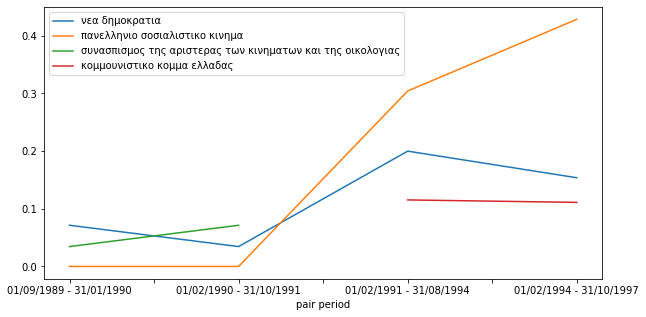

In [89]:
#fig, ax = plt.subplots()
#fig.set_size_inches(18.5, 10.5)
for_plot.plot(figsize=(10,5))
#plt.show()

### Attempt to create loops for topics

3) Find the top neighbours and stem them

In [94]:
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk

party_sims = []
parties = []
periods = []
topics = []
for topic in generic_topics:
  for party in grouped_data.political_party.unique():
    period_number = 4
    for period in grouped_data.parliamentary_period.unique():
      if not grouped_data['speech'].loc[(grouped_data.political_party == party) &
                 (grouped_data.parliamentary_period == period)].empty:
          #print(f"{party}_period{period_number}")
          period_number+=1
          model = Word2Vec.load(f"../out_files/wordmodels/PERperiod_PERparty/{party}_period{period_number}.mdl")
          #print(party)
          #print(model.wv.vocab)
          if topic in model.wv.vocab:
            sims = {k:s for k,s in model.wv.most_similar(positive=[topic], topn=15)} # (kaiti) change topn = 10 to topn =15
            #print(' '.join(sims))
            party_sims.append(' '.join(sims))
            parties.append(party)
            periods.append(period)
            topics.append(topic)
        
dict = {'party': parties, 'period': periods, 'topic': topics, 'neighbors': party_sims} 
nearest_neighbors_sims = pd.DataFrame(dict)

In [95]:
nearest_neighbors_sims

party    period    topic  \
0                  νεα δημοκρατια  period 5  παιδεία   
1                  νεα δημοκρατια  period 6  παιδεία   
2                  νεα δημοκρατια  period 7  παιδεία   
3                  νεα δημοκρατια  period 8  παιδεία   
4                  νεα δημοκρατια  period 9  παιδεία   
..                            ...       ...      ...   
222   κομμουνιστικο κομμα ελλαδας  period 7    άμυνα   
223   κομμουνιστικο κομμα ελλαδας  period 8    άμυνα   
224   κομμουνιστικο κομμα ελλαδας  period 9    άμυνα   
225               πολιτικη ανοιξη  period 8    άμυνα   
226  δημοκρατικο κοινωνικο κινημα  period 9    άμυνα   

                                             neighbors  
0    εκπαίδευση ελλάδα ανάκριση αριστερά κοινωνία γ...  
1    συνολική δημόσια αναπτυξιακή αγορά ελεύθερη αγ...  
2    υγεία τρομοκρατία οικονομία κοινωνία αποκρατικ...  
3    υγεία ευρώπη προεδρία κτηνοτροφία αισθητική αξ...  
4    κτηνοτροφία οικονομία κοινωνία αστυνομία ύπαιθ...  
..                                                 ...  
222  ασφάλεια εθνική ανεξαρτησία αγροτική παραγωγικ...  
223  αναγνώριση σύμβασης εφαρμογή ενημέρωση ίδρυση ...  
224  εθνική παιδεία οικονομία κλαδική ασφάλεια προο...  
225  οικονομία προϋπόθεση έδρα αγροτική ελληνική δι...  
226  εθνική εξουσία εξωτερική αντίληψη δραστηριότητ...  

[227 rows x 4 columns]

In [96]:
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()

stemmed_neighbors = nearest_neighbors_sims['neighbors']
stemmed_neighbors = stemmed_neighbors.str.lower() # make it lower() for maketrans to match below
stemmed_neighbors = stemmed_neighbors.str.translate(
                 str.maketrans('άέόώήίϊΐύϋΰ', 'αεοωηιιιυυυ'))
stemmed_neighbors = stemmed_neighbors.str.upper()

stemmed_words = []
for i in stemmed_neighbors:
  words = nltk.word_tokenize(i)
  stemmed_words.append([stemmer.stem(word) for word in words])
print(stemmed_words)

[['ΕΚΠΑΙΔΕΥΣ', 'ΕΛΛΑΔ', 'ΑΝΑΚΡΙΣ', 'ΑΡΙΣΤΕΡ', 'ΚΟΙΝΩΝ', 'ΓΛΩΣΣ', 'ΕΘΝ', 'ΛΕΠΤΟΜΕΡΕΙ', 'ΕΠΟΧ', 'ΠΡΑΞ', 'ΑΤΜΟΣΦΑΙΡ', 'ΕΝΔΙΑΦΕΡ', 'ΓΕΝΙΚ', 'ΙΔΕ', 'ΑΝΑΓΚΑΙ'], ['ΣΥΝΟΛ', 'ΔΗΜΟΣ', 'ΑΝΑΠΤΥΞΙΑΚ', 'ΑΓΟΡ', 'ΕΛΕΥΘΕΡ', 'ΑΓΡΟΤ', 'ΒΟΗΘΕΙ', 'ΣΥΝΑΙΝΕΣ', 'ΕΝΙΑΙ', 'ΚΑΚ', 'ΕΥΡΩΠΑΙΚ', 'ΚΑΙΝΟΥΡ', 'ΑΝΗΣΥΧ', 'ΚΑΤΗΓΟΡ', 'ΝΟΜΟΘΕΤ'], ['ΥΓΕΙ', 'ΤΡΟΜΟΚΡΑΤ', 'ΟΙΚΟΝΟΜ', 'ΚΟΙΝΩΝ', 'ΑΠΟΚΡΑΤΙΚΟΠΟΙΗΣ', 'ΑΜΥΝ', 'ΚΤΗΝΟΤΡΟΦ', 'ΠΡΟΝΟΙ', 'ΤΟΥΡΚ', 'ΥΠΟΔΟΜ', 'ΤΗΛΕΦΩΝ', 'ΕΚΠΑΙΔΕΥΣ', 'ΑΝΘΡΩΠΟΤΗΤ', 'ΕΥΗΜΕΡ', 'ΠΑΡΑΟΙΚΟΝΟΜ'], ['ΥΓΕΙ', 'ΕΥΡΩΠ', 'ΠΡΟΕΔΡ', 'ΚΤΗΝΟΤΡΟΦ', 'ΑΙΣΘΗΤ', 'ΑΞΙΟΚΡΑΤ', 'ΚΟΙΝΟΤΗΤ', 'ΑΛΙΕΙ', 'ΑΣΤΥΝΟΜ', 'ΕΚΠΑΙΔΕΥΣ', 'ΠΟΛΙΤΕΙ', 'ΠΡΑΓΜΑΤΙΚΟΤΗΤ', 'ΗΠΕΙΡ', 'ΕΛΠΙΔ', 'ΑΣΦΑΛΙΣ'], ['ΚΤΗΝΟΤΡΟΦ', 'ΟΙΚΟΝΟΜ', 'ΚΟΙΝΩΝ', 'ΑΣΤΥΝΟΜ', 'ΥΠΑΙΘΡ', 'ΑΒΕΒΑΙΟΤΗΤ', 'ΥΦΕΣ', 'ΠΡΟΛΗΨ', 'ΕΥΡΩΠ', 'ΑΠΟΚΕΝΤΡΩΣ', 'ΑΛΒΑΝ', 'ΑΤΤΙΚ', 'ΥΓΕΙ', 'ΚΕΦΑΛΑΙΑΓΟΡ', 'ΑΜΥΝ'], ['ΙΣΧ', 'ΚΟΜΜΑΤ', 'ΔΗΜΟΣ', 'ΤΕΧΝΟΛΟΓ', 'ΕΥΡΩΠ', 'ΜΕΙΝ', 'ΑΝΟΙΚΤ', 'ΠΕΡΝ', 'ΝΟΜΟΘΕΣ', 'ΔΥΝΑΜ', 'ΣΥΣΤΗΜΑΤ', 'ΟΠΟΤ', 'ΚΡΑΤΗΣ', 'ΕΝΗΜΕΡΩΣ', 'ΜΟΙΡ'], ['ΔΗΜΟΣΙΟΝΟΜ', 'ΚΟΙΝΟΤΗΤ', 'ΠΑΡΑΓΩΓ', 'ΥΓΕ

In [98]:
period_dates = []
for period in nearest_neighbors_sims.period:
    period_dates.append(f"{data.loc[data.parliamentary_period == period].sitting_date.min()} \
      - {data.loc[data.parliamentary_period == period].sitting_date.max()}")

In [100]:
nearest_neighbors_sims['stemmed neighbors'] = stemmed_words
nearest_neighbors_sims['period with dates'] = period_dates

In [101]:
nearest_neighbors_sims

party    period    topic  \
0                  νεα δημοκρατια  period 5  παιδεία   
1                  νεα δημοκρατια  period 6  παιδεία   
2                  νεα δημοκρατια  period 7  παιδεία   
3                  νεα δημοκρατια  period 8  παιδεία   
4                  νεα δημοκρατια  period 9  παιδεία   
..                            ...       ...      ...   
222   κομμουνιστικο κομμα ελλαδας  period 7    άμυνα   
223   κομμουνιστικο κομμα ελλαδας  period 8    άμυνα   
224   κομμουνιστικο κομμα ελλαδας  period 9    άμυνα   
225               πολιτικη ανοιξη  period 8    άμυνα   
226  δημοκρατικο κοινωνικο κινημα  period 9    άμυνα   

                                             neighbors  \
0    εκπαίδευση ελλάδα ανάκριση αριστερά κοινωνία γ...   
1    συνολική δημόσια αναπτυξιακή αγορά ελεύθερη αγ...   
2    υγεία τρομοκρατία οικονομία κοινωνία αποκρατικ...   
3    υγεία ευρώπη προεδρία κτηνοτροφία αισθητική αξ...   
4    κτηνοτροφία οικονομία κοινωνία αστυνομία ύπαιθ...   
..                                                 ...   
222  ασφάλεια εθνική ανεξαρτησία αγροτική παραγωγικ...   
223  αναγνώριση σύμβασης εφαρμογή ενημέρωση ίδρυση ...   
224  εθνική παιδεία οικονομία κλαδική ασφάλεια προο...   
225  οικονομία προϋπόθεση έδρα αγροτική ελληνική δι...   
226  εθνική εξουσία εξωτερική αντίληψη δραστηριότητ...   

                                     stemmed neighbors  \
0    [ΕΚΠΑΙΔΕΥΣ, ΕΛΛΑΔ, ΑΝΑΚΡΙΣ, ΑΡΙΣΤΕΡ, ΚΟΙΝΩΝ, Γ...   
1    [ΣΥΝΟΛ, ΔΗΜΟΣ, ΑΝΑΠΤΥΞΙΑΚ, ΑΓΟΡ, ΕΛΕΥΘΕΡ, ΑΓΡΟ...   
2    [ΥΓΕΙ, ΤΡΟΜΟΚΡΑΤ, ΟΙΚΟΝΟΜ, ΚΟΙΝΩΝ, ΑΠΟΚΡΑΤΙΚΟΠ...   
3    [ΥΓΕΙ, ΕΥΡΩΠ, ΠΡΟΕΔΡ, ΚΤΗΝΟΤΡΟΦ, ΑΙΣΘΗΤ, ΑΞΙΟΚ...   
4    [ΚΤΗΝΟΤΡΟΦ, ΟΙΚΟΝΟΜ, ΚΟΙΝΩΝ, ΑΣΤΥΝΟΜ, ΥΠΑΙΘΡ, ...   
..                                                 ...   
222  [ΑΣΦΑΛΕΙ, ΕΘΝ, ΑΝΕΞΑΡΤΗΣ, ΑΓΡΟΤ, ΠΑΡΑΓΩΓ, ΟΙΚΟ...   
223  [ΑΝΑΓΝΩΡΙΣ, ΣΥΜΒΑΣ, ΕΦΑΡΜΟΓ, ΕΝΗΜΕΡΩΣ, ΙΔΡΥΣ, ...   
224  [ΕΘΝ, ΠΑΙΔΕΙ, ΟΙΚΟΝΟΜ, ΚΛΑΔ, ΑΣΦΑΛΕΙ, ΠΡΟΟΠΤ, ...   
225  [ΟΙΚΟΝΟΜ, ΠΡΟΥΠΟΘΕΣ, ΕΔΡ, ΑΓΡΟΤ, ΕΛΛΗΝ, ΔΙΚΑΙΟ...   
226  [ΕΘΝ, ΕΞΟΥΣ, ΕΞΩΤΕΡ, ΑΝΤΙΛΗΨ, ΔΡΑΣΤΗΡΙΟΤΗΤ, ΕΠ...   

                 period with dates  
0    01/09/1989       - 29/09/1989  
1    01/02/1990       - 31/01/1990  
2    01/02/1991       - 31/10/1991  
3    01/02/1994       - 31/08/1994  
4    01/04/1997       - 31/10/1997  
..                             ...  
222  01/02/1991       - 31/10/1991  
223  01/02/1994       - 31/08/1994  
224  01/04/1997       - 31/10/1997  
225  01/02/1994       - 31/08/1994  
226  01/04/1997       - 31/10/1997  

[227 rows x 6 columns]

4) Find Jaccard similarity

In [102]:
jac_sims = []
intersections = []
unions = []
parties = []
periods = []
period_dates = []
topics = []
for topic in generic_topics:
  for party in nearest_neighbors_sims.party.unique():
    party_neighbors = nearest_neighbors_sims[(nearest_neighbors_sims.party == party) & (nearest_neighbors_sims.topic == topic)]
    #print(party_neighbors)
    for i in range(5, 5+len(grouped_data.parliamentary_period.unique()) - 1):
      period = 'period '+str(i)
      next_period = 'period '+str(i+1)
      #print(party,i)
      if not ((party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].empty) |
          (party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].empty)):
        #print(party,i)
        jac_sims.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[0])
        intersections.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[1])
        unions.append(jaccard_metrics(party_neighbors['stemmed neighbors'].loc[party_neighbors.period == period].values[0],
                                    party_neighbors['stemmed neighbors'].loc[party_neighbors.period == next_period].values[0])[2])
      else:
        jac_sims.append(np.NaN)
        intersections.append(np.NaN)
        unions.append(np.NaN)
      parties.append(party)
      topics.append(topic)
      periods.append(f"Period {i}-{i+1}")
      period_dates.append(f"{data.loc[data.parliamentary_period == period].sitting_date.min()} - {data.loc[data.parliamentary_period == next_period].sitting_date.max()}")

dict = {'party': parties, 'topic': topics, 'period': periods, 'period_dates': period_dates, 'similarities': jac_sims, 'intesection': intersections, 'union': unions} 
nearest_neighbors_jac_sims = pd.DataFrame(dict)

In [103]:
nearest_neighbors_jac_sims

party    topic      period  \
0                    νεα δημοκρατια  παιδεία  Period 5-6   
1                    νεα δημοκρατια  παιδεία  Period 6-7   
2                    νεα δημοκρατια  παιδεία  Period 7-8   
3                    νεα δημοκρατια  παιδεία  Period 8-9   
4    πανελληνιο σοσιαλιστικο κινημα  παιδεία  Period 5-6   
..                              ...      ...         ...   
391    δημοκρατικο κοινωνικο κινημα    άμυνα  Period 8-9   
392            δημοκρατικη ανανεωση    άμυνα  Period 5-6   
393            δημοκρατικη ανανεωση    άμυνα  Period 6-7   
394            δημοκρατικη ανανεωση    άμυνα  Period 7-8   
395            δημοκρατικη ανανεωση    άμυνα  Period 8-9   

                period_dates  similarities  intesection  union  
0    01/09/1989 - 31/01/1990      0.000000          0.0   30.0  
1    01/02/1990 - 31/10/1991      0.000000          0.0   30.0  
2    01/02/1991 - 31/08/1994      0.111111          3.0   27.0  
3    01/02/1994 - 31/10/1997      0.153846          4.0   26.0  
4    01/09/1989 - 31/01/1990      0.000000          0.0   30.0  
..                       ...           ...          ...    ...  
391  01/02/1994 - 31/10/1997           NaN          NaN    NaN  
392  01/09/1989 - 31/01/1990           NaN          NaN    NaN  
393  01/02/1990 - 31/10/1991           NaN          NaN    NaN  
394  01/02/1991 - 31/08/1994           NaN          NaN    NaN  
395  01/02/1994 - 31/10/1997           NaN          NaN    NaN  

[396 rows x 7 columns]

In [113]:
def create_dataframe(topic, initial_dataframe):
  for_plot = pd.DataFrame()
  filtered_by_topic = initial_dataframe.loc[initial_dataframe.topic == topic]
  for_plot['pair period'] = list(filtered_by_topic.period_dates.unique())
  for party in filtered_by_topic.party.unique():
    for_plot[party] = filtered_by_topic.similarities.loc[nearest_neighbors_jac_sims.party ==
                                                                          party].to_list()
  for_plot = for_plot.set_index('pair period')
  for_plot = for_plot.dropna(thresh=2, axis=1) #keep columns with at least 2 similarities
  return for_plot

In [114]:
create_dataframe('οικονομία', nearest_neighbors_jac_sims)

νεα δημοκρατια  πανελληνιο σοσιαλιστικο κινημα  \
pair period                                                               
01/09/1989 - 31/01/1990        0.071429                        0.000000   
01/02/1990 - 31/10/1991        0.034483                        0.000000   
01/02/1991 - 31/08/1994        0.200000                        0.304348   
01/02/1994 - 31/10/1997        0.153846                        0.428571   

                         συνασπισμος της αριστερας των κινηματων και της οικολογιας  \
pair period                                                                           
01/09/1989 - 31/01/1990                                           0.034483            
01/02/1990 - 31/10/1991                                           0.071429            
01/02/1991 - 31/08/1994                                                NaN            
01/02/1994 - 31/10/1997                                                NaN            

                         κομμουνιστικο κομμα ελλαδας  
pair period                                           
01/09/1989 - 31/01/1990                          NaN  
01/02/1990 - 31/10/1991                          NaN  
01/02/1991 - 31/08/1994                     0.115385  
01/02/1994 - 31/10/1997                     0.111111

Visualize the results in order to draw conclusions. Plot the jaccard similarity only (not intersection, or union metrics) among all the period-pairs, for the selected political party and the selected topic.

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


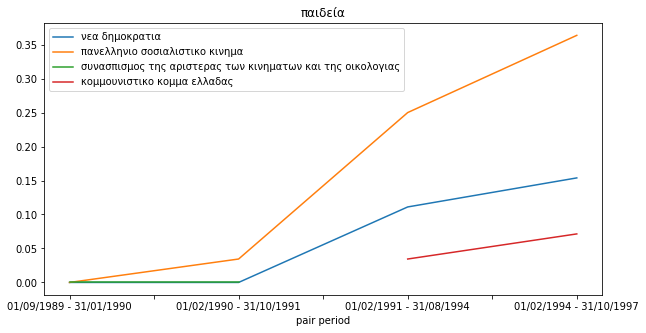

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


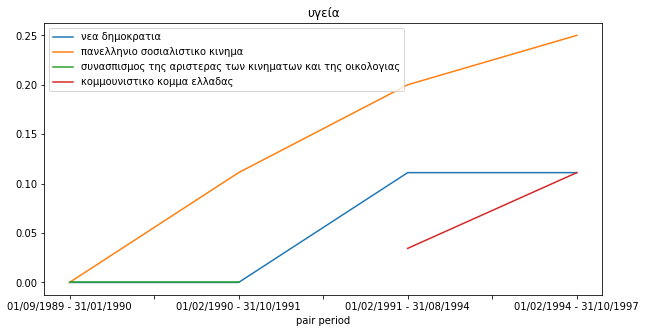

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


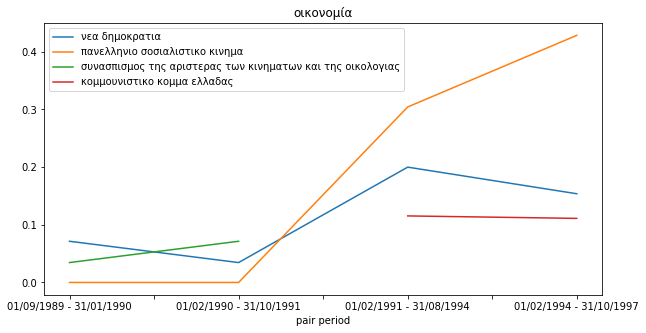

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


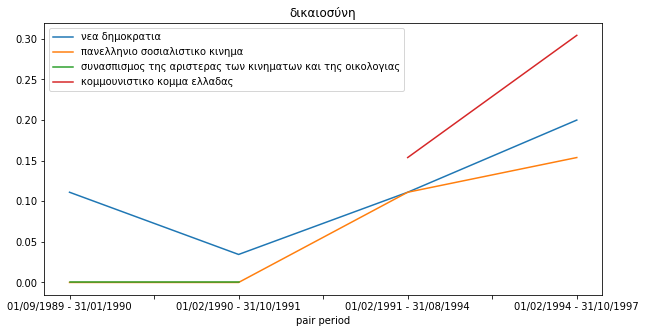

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


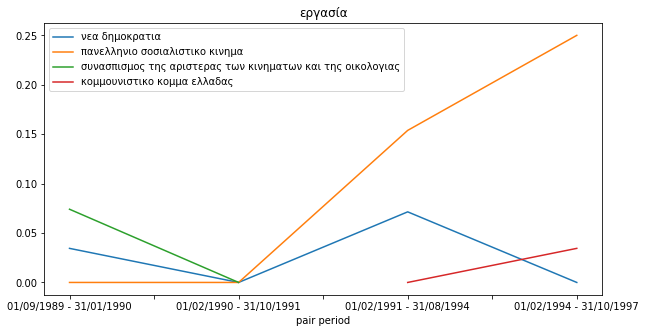

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


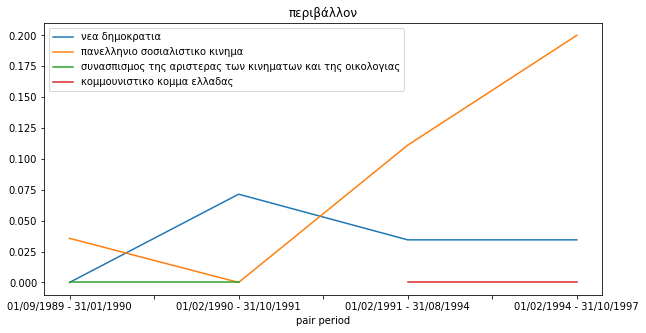

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


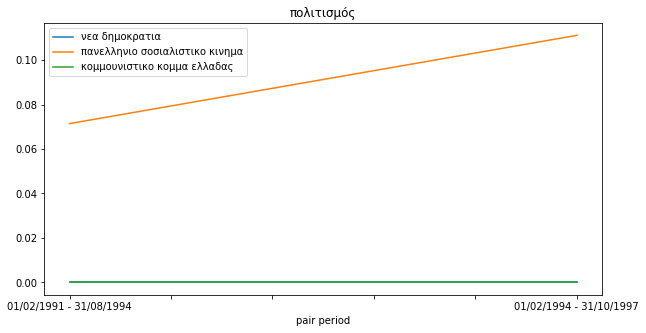

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


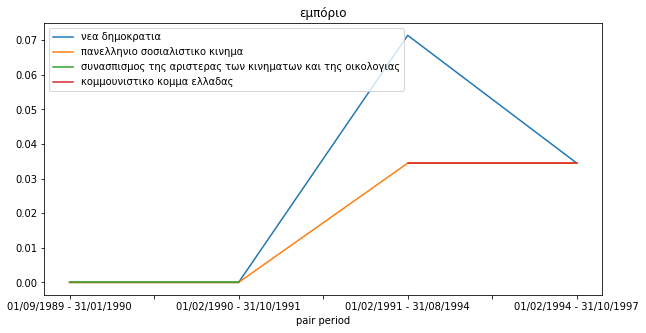

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


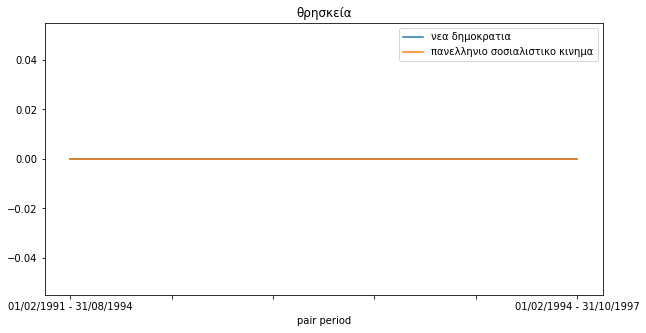

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


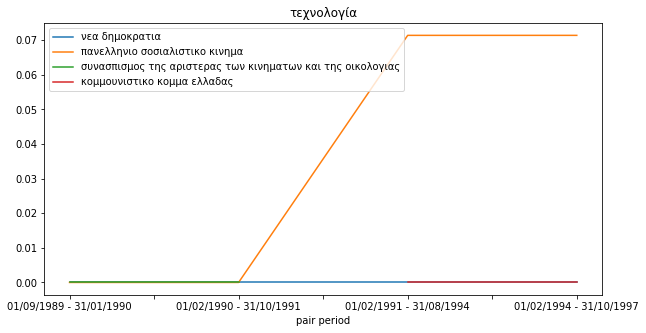

/home/kaiti/.penv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


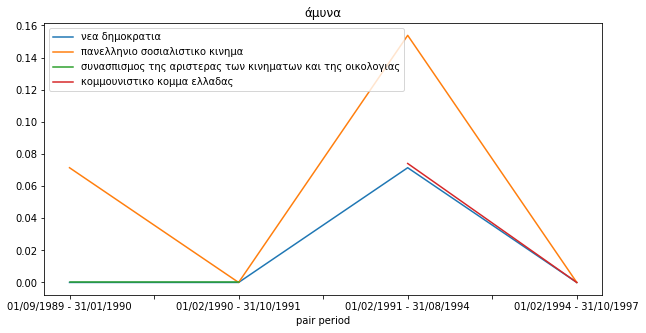

In [145]:
#fig, ax = plt.subplots()
#fig.set_size_inches(18.5, 10.5)
for topic in generic_topics:
  create_dataframe(topic, nearest_neighbors_jac_sims).plot(figsize=(10,5))
  plt.title(topic)
  #print(create_dataframe(topic, nearest_neighbors_jac_sims))
  plt.show()

- PASOK seems to increase the similarity for the most generic topics.
- The greatest similarity concerns the topic "οικονομία" reaching 0,4.
- Neighbours of "θρησκεία", "εμπόριο" and "τεχνολογία" doesn't seem to change enough. 

### 2. Overlap of nearest neighbors for party vectors (dina)

I will look at this, until you finish the above.

In [ ]:
party_name = 'πασοκ'